[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aarondomenzain/tracking-softmatter-aarond/blob/tracking-softmatter-aarond-dev/tutorial/tracking/tracking_spheres.ipynb)

# Particle Tracking Tutorial: Trajectory Linking
In this tutorial, you’ll explore different methods to link particle localizations across time to recostruct trajectories — using both simulated data and real experimental images.

You’ll start by generating a simulated movie of microscopic particles undergoing Brownian motion, mimicking what you might see in a soft matter or biophysics experiment. For each frame, you'll use LodeSTAR, a self-supervised neural network, to detect and localize particles. Then comes the core challenge: linking localization into trajectories.

Here’s what you’ll test and compare:

- Hungarian algorithm (using trackpy — a classic in particle tracking)

- Linear Assignment Problem (LAP) (using laptrack - a more flexible and general framework)

- MAGIK (a geometric deep learning method based on graph neural networks)

You’ll be using Python libraries like NumPy, SciPy, Matplotlib, scikit-image, PyTorch, DeepTrack, and Deeplay. 

## Table of Contents

0. [Import the Required Libraries and Load Utility Functions](#import-the-required-libraries-and-load-utility-functions)
1.  [Load and Visualize Experimental Videos](#load-and-visuzlize-experimental-videos)
2. [Simulate Realistic Videos with DeepTrack](#simulate-realistic-videos-with-deeptrack)
    - [Simulate a Single Particle](#simulate-a-single-particle)
    - [Simulate a Test Image to Benchmark Detection Methods](#simulate-a-test-image-to-benchmark-detection-methods)
<!-- 
2. [Detections with LodeSTAR.](#detections-with-lodestar)\
  [**(a).** Pipeline to train LodeSTAR.](#pipeline-to-train-lodestar)\
  [**(b).** Perform a test detection to a single frame](#perform-a-test-detection-to-adjust-parameters-and-estimate-performance)\
  [**(c).** Perform detections to all frames in a movie.](#apply-lodestar-to-every-frame-of-the-simulation)

3. [Method 1: Trackpy.](#method-1-using-trackpy)\
  [**(a).** Get predictions.](#make-trajectory-list-from-dataframe)\
  [**(b).** Evaluate and generate movie.](#make-and-display-video)\
  [**(c).** Display trajectories.](#display-paired-and-unpaired-trajectories)

4. [Method 2: Laptrack](#method-2-laptrack)\
  [**(a).** Get predictions.](#perform-predictions-on-trajectories)\
  [**(b).** Evaluate and generate movie.](#generate-and-play-movie)

5. [Method 3: MAGIK](#method-3-magik)\
  [**(a).** Generate training data.](#simulate-a-training-dataset)\
  [**(b).** Training MAGIK.](#pipeline-to-train-magik)\
  [**(c).** Get predictions from simulated test data.](#compute-trajectories-from-simulated-data-using-magik-predictions)\
  [**(d).** Evaluate and generate movie.](#evaluate-using-f1-score)\
  [**(e).** Get predictions from experimental data.](#compute-trajectories-from-the-experimental-data-using-magik-predictions)\
  [**(f).** Evaluate and generate movie.](#evaluate-with-f1-score) -->

## Import the Required Libraries and Load Utility Functions

Uncomment the next cell if running on Google Colab/Kaggle.

In [164]:
#!pip install deeptrack deeplay trackpy laptrack -q

In [165]:
# Standard libraries.
import os
import random
import sys
import logging

# Configuration
import matplotlib
matplotlib.rcParams["animation.embed_limit"] = 60  # Allow larger animations inline
logging.disable(logging.WARNING)                   # Suppress warnings and below

# Core Scientific Stack
import numpy as np
import pandas as pd

# Plotting and Display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Machine Learning
import torch
from torchvision.transforms import Compose
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
import deeplay as dl

# Particle Tracking and Simulation
import deeptrack as dt
import trackpy as tp
from laptrack import LapTrack

# External libraries.
import deeptrack as dt
import torch

Load a set of custom functions defined specifically for this notebook from the `utils_linking.py` file. For detailed documentation of each function, refer to the comments and docstrings within `utils_linking.py`.

In [166]:
# Load functions and utilities for dataset generation and visualization.
# Sys append a folder to the path.
sys.path.append(os.path.abspath(os.path.join("..","..", "utils")))

# Import all the functions contained in the file utils/utils_detection.py.
import utils_linking as utils
import utils_detection as utils2

Set random seeds to make results reproducible across runs, especially during training and data simulation.

In [167]:
# Set a fixed seed value
seed = 76

# Python, NumPy, and PyTorch (CPU)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Only set CUDA seeds if a GPU is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Seeds set to {seed} (with CUDA: {torch.cuda.is_available()})")

Seeds set to 76 (with CUDA: False)


## Load and Visualize Experimental Videos

You'll use experimental darkfield video of a system of colloidal particles. Data from https://www.nature.com/articles/s41467-022-30497-z.


In [168]:
# Define the folder and video file name.
video_folder = "videos"
video_file_name = "experimental_video.npy"

# Construct the full path.
video_path = os.path.join(video_folder, video_file_name)

# Load the video data.
exp_video = np.load(video_path)

utils.play_video(exp_video, "Experimental Video")

Display the first frame of the video, manually select and display a single particle by specifying its centroid coordinates (x,y) and a box width.

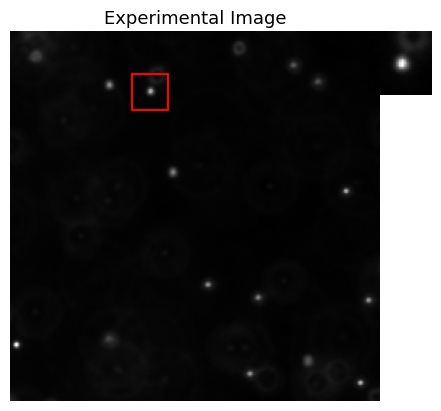

In [169]:
image = exp_video[0]  # Select the first frame of the video.

# Box size to zoom in an individual particle.
width = 25

# Coordinates of the center of the particle.
x_center = 96
y_center = 41

# Calculate top-left corner of the crop.
x = x_center - width // 2
y = y_center - width // 2

# Select a crop as a subset of the entire image.
crop = image[y:y + width, x:x + width]  # row (y), column (x)

# Initialize figure instance.
fig = plt.figure()

# Draw a red rectangle around the crop.
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.title("Experimental Image", size=13)
plt.plot([x, x, x+width, x+width, x],[y, y+width, y+width, y, y], 'r-')
plt.axis('off')

# Plot the rectangle on the top right corner.
fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

## Simulate Realistic Videos with DeepTrack

### Simulate Particles

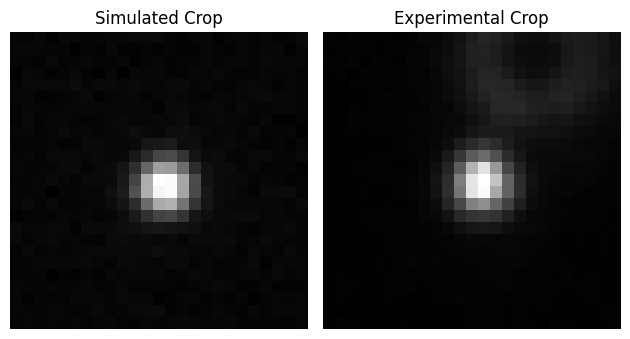

In [170]:
# Same as the box width.
image_size = width  

# Size of a pixel in nanometers in the output image.
pixel_size_nm = 100 # In nm.

# Radius of the particle.
particle_radius = 200 # In nm.

# Define central spherical scatterer.
sphere = dt.Sphere(
    position=0.5 * np.array([image_size, image_size]),
    z= 0 * dt.units.nm, # Particle in focus.
    radius= particle_radius * dt.units.nm,  # Radius in nanometers.
    intensity= 5.1E4,  # Field magnitude squared.
)

# Simulate the properties of the fluorescence microscope.
optics = dt.Fluorescence(
    NA=1.2,  # Numerical aperture.
    wavelength=638 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size_nm * dt.units.nm, # Camera resolution or effective resolution.
)

# Apply transformations.
sim_crop = (
    optics(sphere)
    >> dt.Background(900)
    >> dt.Poisson(snr=4000)
)

# Turn the crop into a NumPy array.
simulated_crop = np.squeeze(sim_crop())

# Plot the simulated and experimental crops.
fig, axes = plt.subplots(1, 2)

# Simulated crop.
plot = axes[0].imshow(simulated_crop, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Crop")

# Experimental crop.
axes[1].imshow(crop, cmap="gray")  
axes[1].axis("off")
axes[1].set_title("Experimental Crop")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

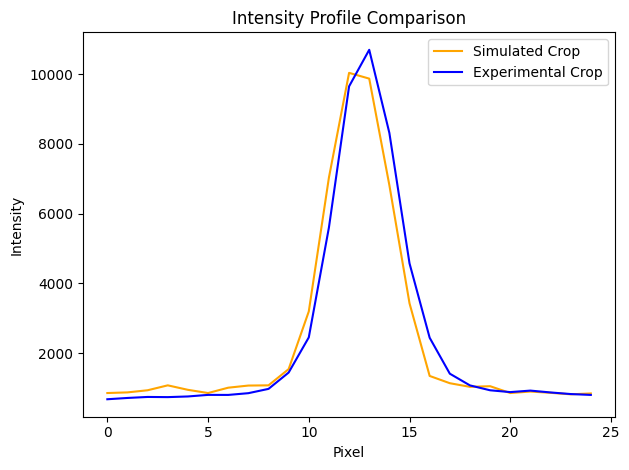

In [171]:
# Calculate and display the raw intensity profile of the simulated experimental crops.
simulated_crop_intensity = simulated_crop[image_size // 2, :]
experimental_crop_intensity = crop[image_size // 2, :]
fig, ax = plt.subplots()
ax.plot(simulated_crop_intensity, label="Simulated Crop", color="orange")
ax.plot(experimental_crop_intensity, label="Experimental Crop", color="blue")
ax.set_xlabel("Pixel")
ax.set_ylabel("Intensity")
ax.set_title("Intensity Profile Comparison")
ax.legend()
plt.tight_layout()
plt.show()

In [175]:
# Parameters of the simulation.
image_size = 256
N_particles = 50
particle_radius = 200  # Particle radius in nm.

# Dictionary for particle properties. Dimensions are set with lambda
# functions to introduce variety to the dataset.
sphere_properties = {
    # "radius": lambda: np.random.uniform(0.95, 1.05) * particle_radius * dt.units.nm,
    "intensity": lambda: np.random.normal(0.8, 0.1)*5.1E4,
    "z": lambda: -np.random.exponential(800) * dt.units.nm,
    "radius": lambda: particle_radius * dt.units.nm,
    # "intensity": lambda: 5.1E4,
    # "z": lambda: 0 * dt.units.nm,
}

# Set the optical properties of the microscope.  
optics_properties = dt.Fluorescence(
    NA=1.2,  # Numerical aperture.
    wavelength=638 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size_nm * dt.units.nm, # Camera resolution or effective resolution.
)

# Generate ground truth positions.
gt_pos = utils2.generate_centroids(
    num_particles=N_particles,
    image_size=image_size,
    particle_radius=particle_radius, 
)

# Simulate image.
simulated_image = utils2.transform_to_video(
    gt_pos,
    image_size=image_size,
    core_particle_props=sphere_properties,
    optics_props=optics_properties,
    background_props={"poisson_snr": 3500, "background_mean": 800},
)

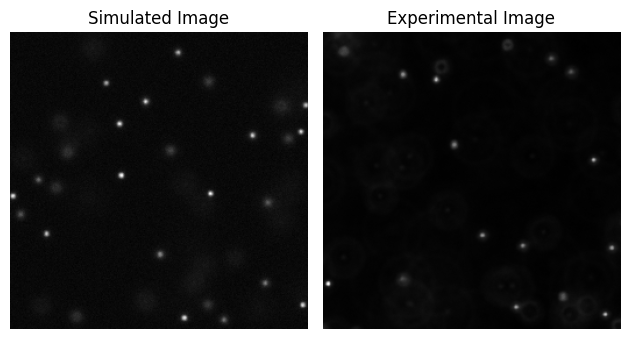

In [176]:
# normalized_image = utils2.normalize_min_max(image)

# Plot the simulated and experimental images.
fig, axes = plt.subplots(1, 2)

# Simulated image.
plot = axes[0].imshow(simulated_image, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Image")

# Experimental image.
axes[1].imshow(image, cmap="gray")  
axes[1].axis("off")
axes[1].set_title("Experimental Image")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

Histogram

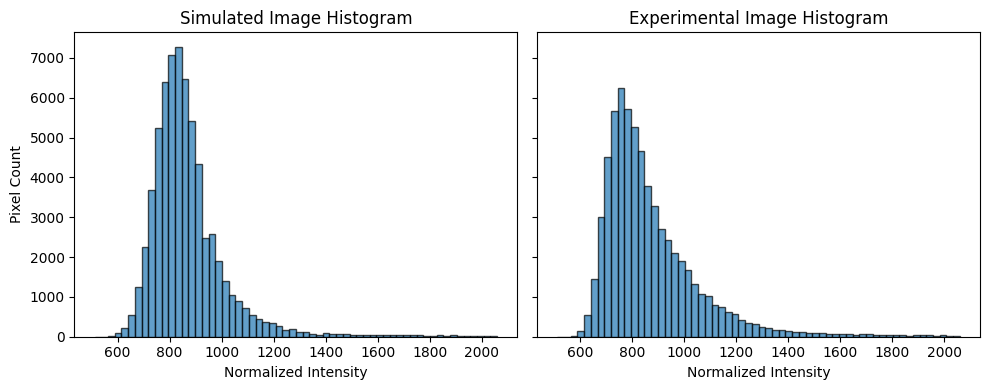

In [178]:
# Flatten the arrays to 1D.
sim_vals = simulated_image.ravel()
exp_vals = image.ravel()

# Compute common bin edges.
all_vals = np.concatenate([sim_vals, exp_vals])
num_bins = 60
bins = np.linspace(all_vals.min(), np.quantile(all_vals,0.99), num_bins + 1)

# Create figure with two subplots sharing axes.
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 4),
    sharey=True, sharex=True,
    tight_layout=True
)

# Histogram for simulated image.
axes[0].hist(
    sim_vals,
    bins=bins,
    alpha=0.7,
    edgecolor="black"
)
axes[0].set_title("Simulated Image Histogram")
axes[0].set_xlabel("Normalized Intensity")
axes[0].set_ylabel("Pixel Count")

# Histogram for experimental image.
axes[1].hist(
    exp_vals,
    bins=bins,
    alpha=0.7,
    edgecolor="black"
)
axes[1].set_title("Experimental Image Histogram")
axes[1].set_xlabel("Normalized Intensity")

plt.show()

### Simulate trajectories

You will simulate a system visually similar to our experimental data in order to compare the performance of various tracking methods. We aim to replicate the Brownian motion of the nanoparticles as seen in the experimental movie, for more details look into the `simulate_Brownian_trajs` function in the utility file `utils_tracking.py`.

In [ ]:
# Simulation parameters.
box_length = image_size//2
number_particles = 15
number_timesteps = 20
particle_radius = 3

# Simulate trajectories for one video.
trajs_gt = utils.simulate_Brownian_trajs(
    number_particles,
    number_timesteps,
    particle_radius,
    box_length,
)

# Break trajectories going in/out of FOV.
trajs_gt_list = utils.traj_break(
    trajs_gt,
    box_length,
    trajs_gt.shape[1],
)

### Generate movie and compare with experimental data.
With the use of DeepTrack, we simulate spherical scatterers that follow the trajectories that we simulated. The function `transform_to_video` contained in the `utils_tracking.py` file contains the code to simulate particles and visualize them under a microscope with various optics.

In [ ]:
# # Eliminate axis with frames from trajs_gt with numpy.delete().
# simulated_movie = utils2.transform_to_video(
#     np.delete(trajs_gt, 2, 2),
#     image_size=int(2 * box_length),
#     save_video=True,
#     # maps=False,
#     path="./myvideo.tiff",
# )

# Simulate image.
simulated_movie = utils2.transform_to_video(
    np.delete(trajs_gt, 2, 2), # Remove frame axis.
    image_size=image_size,
    core_particle_props=sphere_properties,
    optics_props=optics_properties,
    background_props={"poisson_snr": 3500, "background_mean": 800},
    save_video=True,
    path="videos/simulated_video.tiff",
)

# Play both movies and compare.
utils.play_video(simulated_movie, "Simulated Movie")
utils.play_video(exp_video, "Experimental Movie")

### Detections with LodeSTAR.
LodeSTAR will be used to detect the particles' positions at each frame of the video, as shown in the **Detections** notebooks of this tutorial. Later, these positions will be passed to different tracking methods to compare their performance.

We start by obtaining crops of our particles, this is the most labour intensive part.


In [ ]:
# Provide coordinates and width of crop windows.
y = 197
x = 218
width = 20
crop_1 = video_frame[x : x + width, y : y + width]

y = 97
x = 144
width = 20
crop_2 = video_frame[x : x + width, y : y + width]

y = 232
x = 234
width = 20
crop_3 = video_frame[x : x + width, y : y + width]

y = 58
x = 202
width = 20
crop_4 = video_frame[x : x + width, y : y + width]

# Add crops to list.
crops = [crop_1, crop_2, crop_3, crop_4]

# Plot the crops.
fig, axs = plt.subplots(1, len(crops))
for index, crop in enumerate(crops):
  axs[index].imshow(crop, cmap="gray")
  axs[index].axis("off")
fig.suptitle("Experimental crops for training", size=18)
fig.tight_layout()
plt.show()

### Pipeline to train a LodeSTAR model.
We initiate the training pipeline and data loaders needed for training.\
In the training pipeline we utilize meanpooling to downsample the data as well as adding a small ammount of Gaussian noise, which in turn reduces training time and improves detection performance.


In [ ]:
# Convert list of crops into a numpy array for training LodeSTAR.
experimental_crop_tensor = np.array(crops)

# Random selector of crops.
random_crop = lambda: random.choice(experimental_crop_tensor)

# Initiate LodeSTAR.
lodestar_exp = dl.LodeSTAR(
    n_transforms=4,
    optimizer=dl.Adam(lr=1e-3),
).build()

# Define training pipeline with augmentations.
training_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax(0.1, 0.9)
    >> dt.Pool(np.mean, 2)
    >> dt.Gaussian(0, 0.03)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

# Define dataset.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=512,
)

# Define Dataloader.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

### Train or load weights.
With your desired pipeline and training parameters specified, it is now time to train (or load pre-existing weights).\
Note: The optimal number of training epochs for LodeSTAR can vary anywhere between 10 to 100 epochs depending on your dataset length and batch size.

In [ ]:
force_training = True

# Check if weights exist.
if not os.path.isfile("lodestar_weights_exp") or force_training:

    # Define training settings in a trainer instance.
    trainer_lodestar = dl.Trainer(max_epochs=50)

    # Start training.
    trainer_lodestar.fit(lodestar_exp, dataloader)
    torch.save(
        lodestar_exp.state_dict(),
        "lodestar_weights_exp",
    )
    
else:

    # Load pre-existing weights.
    lodestar_exp.load_state_dict(
        torch.load(
            "lodestar_weights_exp",
            weights_only=True
        )
    )
    
# Set the model to evaluation mode.
lodestar_exp.eval();

### Perform a test detection to adjust parameters and estimate performance.

Once training has finished, we evaluate the accuracy of LodeSTAR detections first on our simulated data.

The three parameters `alpha`, `beta`, `cutoff` need to be adjusted untill you have the desired performance, i.e only particles detected, no false positives.
Note that these parameters are completely dependant on how the training was performed.

In [ ]:
# Format according to the (N,C,X,Y) convention.
image_of_particles = utils.format_image(simulated_movie[0])

# Parameters for inference.
alpha = 0.1
beta = 1 - alpha
cutoff = 0.02

# Get detections from experimental image.
test_detections = lodestar_exp.detect(
    image_of_particles,
    alpha=alpha,
    beta=beta,
    mode="constant",
    cutoff=cutoff,
)[0]

# Print detection number for reference.
number_detections = len(test_detections[:, 1])
print(f"Found {number_detections} test detections.")

# Plot video frame.
plt.figure()
plt.imshow(
    image_of_particles.squeeze(),
    cmap="gray",
)

# Overlay with scatter plot.
plt.scatter(
    test_detections[:, 1],
    test_detections[:, 0],
    marker="o",
    edgecolors="r",
    facecolors="none",
    linewidths=1,
    s=100,
    label="LodeSTAR predictions",
)

# Plot the ground truth positions.
plt.scatter(
    trajs_gt[0, :, 1],
    trajs_gt[0, :, 0],
    c="c",
    marker="+",
    linewidths=1,
    s=90,
    label="Ground truth positions",
)

plt.legend()
plt.title("LodeSTAR detections")
plt.axis("off")
plt.show()

Iteratively apply LodeSTAR to every frame of the simulation.

In [ ]:
# Define a dataframe to store all the LodeSTAR detections.
df_exp = []
for frame_index, frame in enumerate(simulated_movie):

    # Reshape image, needs to be in (N, C, X, Y) format.
    image_for_lodestar = utils.format_image(frame)

    # Get detections from LodeSTAR.
    detections = lodestar_exp.detect(
        image_for_lodestar,
        alpha=alpha,
        beta=beta,
        cutoff=cutoff,
        mode="constant",
    )[0]

    # Process and add to dataframe.
    _df = pd.DataFrame(detections, columns=["x", "y"])
    _df["frame"] = frame_index
    df_exp.append(_df)

    # Print no. of detections every 10 frames.
    if frame_index % 10 == 0:
        print(f"Detections in frame {frame_index}: {len(detections)}")

# Concatenate and process dataframe.
DF_exp = pd.concat(df_exp, ignore_index=True)
DF_exp.__len__()
DF_test = DF_exp.rename(
    columns = {"y":"centroid-1",
               "x":"centroid-0"}
)

# Add label set solution columns.
DF_test["label"] = 0
DF_test["set"] = 0
DF_test["solution"] = 0

# Normalize centroids between 0 and 1.
_length = frame.shape[0]
_width  = frame.shape[1]
DF_test.loc[:, DF_test.columns.str.contains("centroid")] = (
    DF_test.loc[:, DF_test.columns.str.contains("centroid")]
    / np.array([_length, _width])
)

print("Finished generating dataframe.")

Once we are satisfied with our test detection, we will then get detections from all the frames from our movie with simulated trajectories.

The performance in this step is reliant on how visually similar your experimental data is to your simulated data, as LodeSTAR is trained on an experimental crop.

## Method 1: Using `TrackPy`
TrackPy utilizes a modified version of the Crocker-Grier method to generate trajectories. Note that this time, the particles' positions need to be contained in a Pandas Dataframe.

Click [here](https://soft-matter.github.io/trackpy/dev/tutorial/prediction.html) for more information on the specifics of the linking method.


In [ ]:
# Use the function trackpy.link() to link the detections at each frame
# according to a specified criteria, such as search range radius and
# missing frames memory.
trajectory_1 = tp.link(
    DF_exp,
    search_range=20,
    memory=1,
)

# Print the header of the dataframe with the first 5 rows.
trajectory_1.head()
print(f"Trajectory length: {len(trajectory_1)}")

### Make trajectory list from dataframe.

In [ ]:
trajs_list_method_1 = []
for i in trajectory_1.particle.drop_duplicates():
    _t = trajectory_1.loc[trajectory_1.particle == i,
     ["frame", "x", "y"]].values
    trajs_list_method_1.append(_t )

### Make and display video with both the prediction and ground truth.

In [ ]:
trackpy_video = utils.make_video_with_trajs(
    trajs_list_method_1,
    trajs_gt_list,
    simulated_movie,
    box_length,
)

# Display the video.
trackpy_video

Evaluate the performance of the tracking method with the following metrics: \

TP: True Positives.\
FP: False Positives.\
FN: False Negatives.\
alpha: Indicates the overall degree of matching of ground-truth and estimated tracks without taking into account spurious (nonpaired estimated) tracks (as explained in https://www.nature.com/articles/nmeth.2808).
beta: Essentially expresses alpha with a penalization on non-paired tracks.

In [ ]:
# Print performance metrics.
utils.trajectory_metrics(
    trajs_gt_list,
    trajs_list_method_1,
    eps=5,
);

### Display paired (and unpaired) trajectories.

In [ ]:
#  Compute the total squared distance between all trajectories to match
#  predicted trajectories with ground truth.
trajectory_pairs, _, _ = utils.trajectory_assignment(
    trajs_gt_list,
    trajs_list_method_1,
    eps=5,
)

# Plot the trajectories.
fig = plt.figure(figsize=(6, 6))
colors = np.random.rand(len(trajectory_pairs[0]), 3)


for  pair, c0 in zip(zip(trajectory_pairs[0], trajectory_pairs[1]), colors):
     plt.plot(
         trajs_list_method_1[pair[1]][:, 2],
         trajs_list_method_1[pair[1]][:, 1],
         color=c0,
         linewidth=4,
     )

     plt.plot(
         trajs_gt_list[pair[0]][:, 2],
         trajs_gt_list[pair[0]][:, 1],
         color="k",
         linewidth=1,
     )

plt.legend(["Predicted", "Ground Truth"])

# Process unpaired trajectories.

# Plot false negatives.
if len(trajs_gt_list) > len(trajectory_pairs[0]):
    unpaired_indices = [i for i in range(len(trajs_gt_list))
                        if i not in trajectory_pairs[0]]
    for idx in unpaired_indices:
        coordinates = trajs_gt_list[idx]
        plt.plot(
            coordinates[:, 2],
            coordinates[:, 1],
            color="k",
            linewidth=1,
        )
        
# Plot false positives.
if len(trajs_list_method_1) > len(trajectory_pairs[1]):
    unpaired_indices = [i for i in range(len(trajs_list_method_1))
                        if i not in trajectory_pairs[1]]
    for idx in unpaired_indices:
        coordinates = trajs_list_method_1[idx]
        plt.plot(
            coordinates[:, 2],
            coordinates[:, 1],
            color="red",
            linewidth=1,
        )

##  Method 2: `LapTrack`
LapTrack utilizes the Linear Assignment Problem (LAP) with cost functions to link together trajectories. The cost function takes into account the distance between particle positions accross consecutive frames. Shorter distances imply lower cost values. By efficiently solving the LAP, LapTrack identifies the best matches for particles across frames, reconstructing the trajectories with highest lowest associated cost, i.e., highest associated probability.\
Examples of using LapTrack can be found here [here](https://github.com/yfukai/laptrack/tree/main/docs/examples).

### Perform predictions on trajectories.

In [ ]:
# Set a maximum distance in pixel units
max_distance = 25
laptrack = LapTrack(
    track_cost_cutoff=max_distance,
    gap_closing_max_frame_count=2,
)

trajectory_2, _, _ = laptrack.predict_dataframe(
    DF_exp,
    ["x", "y"],
    only_coordinate_cols=True,
)

trajectory_2 = trajectory_2.reset_index()

# Print the first 5 rows.
trajectory_2.head()

### Make trajectory list from dataframe.

In [ ]:
trajs_list_method_2=[]
for i in trajectory_2.track_id.drop_duplicates():
    _t = trajectory_2.loc[trajectory_2.track_id == i,
     ["frame", "x", "y"] ].values
    trajs_list_method_2.append(_t )

### Generate and play movie.

In [ ]:
laptrack_video = utils.make_video_with_trajs(
    trajs_list_method_2,
    trajs_gt_list,
    simulated_movie,
    box_length,
)
laptrack_video

### Evaluate trajectory metrics.

In [ ]:
utils.trajectory_metrics(
    trajs_gt_list,
    trajs_list_method_2,
    eps=5,
);

In [ ]:
# Compute the trajectory assignment using the Hungarian algorithm.
# This returns trajectory indices which pairs the ground truth with
# the corresponding prediction.

trajectory_pairs, _, _ = utils.trajectory_assignment(
    trajs_gt_list,
    trajs_list_method_2,
    eps=5,
)
# Plot the trajectories.
fig = plt.figure(figsize=(6, 6))
colors = np.random.rand(len(trajectory_pairs[0]), 3)

for  pair, c0 in zip(zip(trajectory_pairs[0], trajectory_pairs[1]), colors): #made single zip
     plt.plot(
         trajs_list_method_2[pair[1]][:, 2],
         trajs_list_method_2[pair[1]][:, 1],
         color=c0,
         linewidth=4,
     )
     plt.plot(
         trajs_gt_list[pair[0]][:, 2],
         trajs_gt_list[pair[0]][:, 1],
         color="k",
         linewidth=1,
     )
plt.legend(["Predicted", "Ground Truth"])

# Plot false negatives.
if len(trajs_gt_list) > len(trajectory_pairs[0]):
    unpaired_indices = [i for i in range(len(trajs_gt_list))
                        if i not in trajectory_pairs[0]]

    for idx in unpaired_indices:
        coordinates = trajs_gt_list[idx]
        plt.plot(
            coordinates[:, 2],
            coordinates[:, 1],
            color="k",
            linewidth=1,
        )

# Plot false positives.
if len(trajs_list_method_2) > len(trajectory_pairs[1]):
    unpaired_indices = [i for i in range(len(trajs_list_method_2))
                        if i not in trajectory_pairs[1]]

    for idx in unpaired_indices:
        coordinates = trajs_list_method_2[idx]
        plt.plot(
            coordinates[:, 2],
            coordinates[:, 1],
            color="red",
            linewidth=1,
        )

## Method 3: MAGIK

**MAGIK** is a framework which provides **M**otion **A**nalysis through **G**NN **I**nductive **K**nowledge, and is used to primarily track active matter such as bacteria or colloids, which makes it suitable for the task at hand in seeing how it compares to LapTrack and TrackPy.

### Training MAGIK

In order to train MAGIK we will need to generate training data.
As the experimental data used here depict colloids diffusing with pure Brownian motion, the function `simulate_Brownian_trajs` will generate similar trajectories.

When training MAGIK it is important that the simulated data (in most cases this will be trajectories) have the same characteristic motion as the particles in your experimental data.
Should your experimental data have pure Brownian motion then the simulation should as well. Should your experimental data contain driven flow (in the case of nanofluidics) then you need to account for that as well.

In [ ]:
# Parameters for training dataset.
train_dataset_size = 20
train_number_particles = 20
train_number_timesteps = 50
train_particle_radius = 2
train_box_length = 100

# Initiate a dataframe
df = []
for video_idx in range(train_dataset_size):
    # Simulate trajectories for one video.
    trajs_training = utils.simulate_Brownian_trajs(
        train_number_particles,
        train_number_timesteps,
        train_particle_radius,
        train_box_length,
    )
    # Break trajectories going in/out of FOV.
    _trajs_list_training = utils.traj_break(
        trajs_training,
        train_box_length,
        train_number_particles,
    )
    # Make into dataframe with "frame"(which frame in the video),
    #  label(which particle in that frame), set (which video).
    for _i, _t in enumerate(_trajs_list_training):
        _df = pd.DataFrame(
            _t[:, 1:],
            columns=["centroid-0", "centroid-1"],
        )
        _df["frame"] = _t[:, 0].astype(int)
        _df["label"] = _i
        _df["set"] = f"{video_idx}"
        df.append(_df)
    print(f"Finished generating movie {video_idx}/{train_dataset_size}")

# Concatenate to dataframe.
df_train = pd.concat(df, ignore_index=True)

# Normalize centroids between 0 and 1.
norm_factor = np.array([2.0 * box_length, 2.0 * box_length])
df_train.loc[:, df_train.columns.str.contains("centroid")] = (
    df_train.loc[:, df_train.columns.str.contains("centroid")] / norm_factor
)
df_train.head()

### Define graph extraction class.
To train MAGIK with the simulated trajectories, first we need to produce a graph representation with the function `GraphFromTrajectories`, defined in the utility file `utils.py`.


In [ ]:
# Instance the graph constructor.
graph_constructor = utils.GraphFromTrajectories(
    connectivity_radius=0.1,
    max_frame_distance=3,
)

# Generate graph from training data using graph constructor.
train_graph = graph_constructor(
    df=df_train,
)
print(train_graph)

### Pipeline to train MAGIK
The code to train MAGIK looks a little different than for LodeSTAR, but is structured in the same way.\

The dataset is initialized as its own class with augmentations to diversify the training data with rotations, flips, and node dropouts.\
Afterwards comes the train loader which will batch our dataset during training later on.


In [ ]:
# Initialize the graph dataset class.
# Specify augmentations with transform,
# NodeDropout() should be last.
train_set = utils.GraphDataset(
    train_graph,
    dataset_size=train_dataset_size,
    Dt=5,
    transform=Compose(
        [
            utils.RandomRotation(),
            utils.RandomFlip(),
            utils.NodeDropout(),
        ]
    )
)

# Initialize the training data loader.
train_loader = DataLoader(
    train_set,
    batch_size=2,
    shuffle=True,
    drop_last=True,
)

### Initialize MAGIK.
The initalization parameters used in this notebook are identical to the ones used in the MAGIK model found in [this example](https://github.com/DeepTrackAI/DeepTrack2/blob/develop/examples/MAGIK/Tracking_hela_cells.ipynb) and work well for cell tracking and segmentation.

In [ ]:
model = dl.GraphToEdgeMAGIK(
    [96,] * 4,1,
    out_activation=torch.nn.Sigmoid
)

model.encoder[0].configure(
    hidden_features=[32, 64],
    out_features=96,
    out_activation=torch.nn.ReLU,
)

model.encoder[1].configure(
    hidden_features=[32, 64],
    out_features=96,
    out_activation=torch.nn.ReLU,
)

model.head.configure(hidden_features=[64, 32]);

classifier = dl.BinaryClassifier(
    model=model,
    optimizer=dl.Adam(lr=1e-3),
).build()

### Load pretrained model or train a new one.
MAGIK benefits from a high epoch number (100-200) and trains faster in general than LodeSTAR.



In [ ]:
load_model = False

if load_model:
    print("Loading model...")
    model.load_state_dict(
        torch.load(
            "./models/MAGIK.h5",
            weights_only=True,
        )
    )
else:
    # Set training parameters.
    trainer = dl.Trainer(max_epochs=200)

    # Start training.
    trainer.fit(
        classifier,
        train_loader,
    )
    print("saving model...")
    os.makedirs(
        "models/",
        exist_ok=True,
    )
    torch.save(
        model.state_dict(),
        "./models/MAGIK.h5",
    )

model.eval();

### Evaluating performance.
Using ground truth trajectories, we generate a graph representation of this and feed it to MAGIK.

In [ ]:
# Create dataframe from ground truth.
reshaped_trajectories_df = trajs_gt.reshape(-1, 3)

# Define dataframe from trajectories
df_test = pd.DataFrame(
    reshaped_trajectories_df,
    columns=["centroid-1", "centroid-0", "frame"],
)

# Convert frame column to integer.
df_test["frame"] = df_test["frame"].astype(int)

# Swap x y labels.
df_test["centroid-0"], df_test["centroid-1"] = \
    df_test["centroid-1"], df_test["centroid-0"]
df_test["label"], df_test["set"], df_test["solution"] = 0, 0, 0

# Normalize centroids with height and width of the simulation box.
norm_factor = np.array([2.0 * box_length, 2.0 * box_length])
df_test.loc[:, df_test.columns.str.contains("centroid")] = (
    df_test.loc[:, df_test.columns.str.contains("centroid")] / norm_factor
)

# Generate a graph from graph_constructor. As test_graph returns a list of
#  graphs, we select the first element from the list as it only has 1 element.
test_graph = graph_constructor(df=df_test)[0]
print(test_graph)

### Evaluate using F1 score.
By comparing predictions with the ground truth labels, we can obtain an F1 score using sklearn and get an idea of how good the training went.

In [ ]:
# Set the model to evaluation mode.
classifier.eval();

# Perform prediction on test graph, then compare with ground truth
# to get F1 score.
predictions = classifier(test_graph)
predictions = predictions.detach().numpy() > 0.5
ground_truth = test_graph.y
score = f1_score(ground_truth, predictions)

print(f"Test F1 score: {score}")

### Compute trajectories from the graph using MAGIK predictions.

In [ ]:
trajectory_constructor = utils.ComputeTrajectories()
trajs_from_graph = trajectory_constructor(
    test_graph,
    predictions.squeeze(),
)

### Generate and play movie.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
def update(frame):
    display_frame = simulated_movie[frame]

    ax.clear()
    ax.imshow(display_frame, cmap="gray")
    ax.set_xlim(0, display_frame.shape[1])
    ax.set_ylim(display_frame.shape[0], 0)

    for i, t in enumerate(trajs_from_graph):

        # Extract video frame from graph.
        frames = test_graph.frames[list(t)]

        # Centroids are normalized, so they need to be upscaled
        # as we want their real positions in the image.
        xy_all = test_graph.x[list(t)] * 2 * box_length
        xy_frame = xy_all[frames == frame + 1]

        # Plot markers and lines that trail behind.
        if len(xy_frame) != 0:
            ax.scatter(
                xy_frame[:, 1],
                xy_frame[:, 0],
                edgecolors="r",
                marker="o",
                facecolors="none",
                linewidths=1,
                s=90,
            )
            ax.text(
                xy_frame[0, 1],
                xy_frame[0, 0],
                str(i),
                fontsize=15,
                c="w",
            )
            xy_previous = xy_all[(frames <= frame) & (frames >= frame - 5)]
            ax.plot(
                xy_previous[:, 1],
                xy_previous[:, 0],
                c="w",
            )
            ax.plot(
                xy_frame[max(0, frame - 5):frame, 1],
                xy_frame[max(0, frame - 5):frame, 0],
                c="w",
            )
    return ax

# Make and display animation.
animation = FuncAnimation(
    fig,
    update,
    frames=len(simulated_movie)
)
video = HTML(animation.to_jshtml()); plt.close()
video

## Apply MAGIK to experimental data.
We use our previously trained LodeSTAR model to get detections from experimental data and generate a graph from the dataframe.

In [ ]:
df_exp = []
for frame_index, frame in enumerate(experimental_video):
    # Reshape image, needs to be in (N, C, X, Y) format.
    image_for_lodestar = utils.format_image(frame)

    # Get detections from LodeSTAR.
    detections = lodestar_exp.detect(
        image_for_lodestar,
        alpha=alpha,
        beta=beta,
        cutoff=cutoff,
        mode="constant",
    )[0]

    # Make into dataframe entry.
    _df = pd.DataFrame(detections, columns=["x", "y"])

    # Add frame id column and append.
    _df["frame"] = frame_index
    df_exp.append(_df)

    # Print every 10 frames no. of detections.
    if frame_index % 10 == 0:
        print(f"Detections in frame {frame_index}: {len(detections)}")

DF_test = pd.concat(df_exp, ignore_index=True)
DF_test.__len__()
DF_test = DF_test.rename(columns = {"y":"centroid-1", "x":"centroid-0"})
DF_test["label"], DF_test["set"], DF_test["solution"] = 0, 0, 0

# Normalize centroids between 0 and 1.
_length = frame.shape[0]
_width  = frame.shape[1]
factor = np.array([_length, _width])
DF_test.loc[:, DF_test.columns.str.contains("centroid")] = (
    DF_test.loc[:, DF_test.columns.str.contains("centroid")] / factor
)
print("Finished generating dataframe.")

# Generate a graph from graph_constructor.
# Since graph_constructor returns a list of graphs,
# we select the first element from the list as it only has 1 element.
test_graph = graph_constructor(df=DF_test)[0]
print(test_graph)

### Evaluate with F1 score.

In [ ]:
classifier.eval()
predictions = classifier(test_graph)

predictions = predictions.detach().numpy() > 0.5
ground_truth = test_graph.y
score = f1_score(ground_truth, predictions)
print(f"Test F1 score: {score}")

### Compute trajectories from the experimental data using MAGIK predictions.

In [ ]:
trajectory_constructor = utils.ComputeTrajectories()
trajs_from_graph = trajectory_constructor(
    test_graph,
    predictions.squeeze()
)

### Generate and play movie.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
def update(frame):
    display_frame = experimental_video[frame]
    ax.clear()
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.imshow(display_frame, cmap="gray")

    for i, t in enumerate(trajs_from_graph):

        # Extract video frame from graph.
        frames = test_graph.frames[list(t)]

        # Extract normalized centroids from graph.
        xy_all = test_graph.x[list(t)]
        xy_frame = xy_all[frames == frame]

        # Centroids are normalized, so they need to be upscaled
        # as we want to get their real positions in the image.
        scale_factor = np.asarray(
            [display_frame.shape[1],
             display_frame.shape[0]]
        )
        xy_frame *= scale_factor

        # Plot markers and lines that trail behind.
        if len(xy_frame) != 0:
            ax.scatter(
                xy_frame[:, 1],
                xy_frame[:, 0],
                edgecolors="r",
                marker="o",
                facecolors="none",
                linewidths=1,
                s=90,
            )
            ax.text(
                xy_frame[0, 1],
                xy_frame[0, 0],
                str(i),
                fontsize=15,
                c="w",
            )
            xy_previous = xy_all[(frames <= frame) & (frames >= frame - 5)]
            ax.plot(
                xy_previous[:, 1],
                xy_previous[:, 0],
                c="w",
            )
            ax.plot(
                xy_frame[max(0, frame - 5):frame, 1],
                xy_frame[max(0, frame - 5):frame, 0],
                c="w",
            )
    return ax

# Make and display animation.
animation = FuncAnimation(
    fig,
    update,
    frames=len(experimental_video),
)
video = HTML(animation.to_jshtml()); plt.close()
video


### Save movie.
If you wish to save the movie, uncomment the code cell below. This will generate a directory of movie frames, along with a html player and a gif file.


In [ ]:
"""
from PIL import Image

# Save html animation
animation.save(f"tracking_movie.html", writer="html")

# Prepare frames to save animation as gif.
frames = [os.path.join("tracking_movie_frames", f) for f in\
sorted(os.listdir("tracking_movie_frames")) if f.endswith('.png')]

# Open frames as images
images = [Image.open(frame) for frame in frames]

# Save as a GIF
images[0].save(
    "track.gif",
    save_all=True,
    append_images=images[1:],
    duration=100,
    loop=0,
)
"""